# Kaggle Taxi Cab Analysis

## Loading Libraries and Datasets

Importing pandas, pytorch and numpy

In [3]:
import pandas as pd
import torch, numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import os 
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 1.9.0+cu111


Name for Saving Model and Predictions

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Read in the train.csv file into a pandas dataframe.

In [5]:
df_tr = pd.read_csv("train.csv")

In [6]:
print(df_tr.shape)
df_tr.head()

(1710670, 9)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


Removing the 10 trips with MISSING_DATA true meaning they have no POLYLINE and thus no travel time.

In [7]:
missingIndex = df_tr[df_tr["MISSING_DATA"]].index
df_tr.drop(missingIndex , inplace=True)

In [8]:
print(df_tr.shape)
df_tr.head()

(1710660, 9)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# Get Computed Travel Time

Add a "LEN" column to the dataframe with a trip's travel time calculated by getting the number of elements in the POLYLINE and multiplying by 15 seconds. A single element in the POLYLINE represents a start longtitude/latitude and an end longtitude/latitude and represents 15 seconds of travel.

In [9]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

Translates the TIMESTAMP which is in epoch time into YR, MON, DAY, HR, WK columns.

In [10]:
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")


In [11]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0


# Feature Engineering

For this, the chosen features are the hours, month and day that the trip occured on and the call_type. Instead of the categorical representation, their one hot representations will be used. These will be combined into a tensor with the shape [1710660, 72] or in otherwords we have 1710660 feature vectors each of length 72. The length of the trips will be turned into a tensor as well and we want its shape to be [1710660, 1] so we might need to reshape it.

In [12]:
def transform(data, num_category):
    one_hot = np.zeros(num_category)
    one_hot[data] = 1
    return one_hot

def transform24(data):
    return transform(data, 24)

def transform12(data):
    return transform(data, 13)

def transform32(data):
    return transform(data, 32)

def transformCallType(data):
    if data == 'A':
        return (1,0,0)
    elif data == 'B':
        return (0,1,0)
    else :
        return (0,0,1)



In [13]:
def getFeatureVectors(dataframe):
    one_hot_hours = dataframe["HR"].apply(transform24)
    one_hot_month = dataframe["MON"].apply(transform12)
    one_hot_days = dataframe["DAY"].apply(transform32)
    one_hot_call = dataframe["CALL_TYPE"].apply(transformCallType)
    #turn the three series into tensors and concat them horizontally
    hours = torch.tensor(one_hot_hours, dtype=torch.float32)
    month = torch.tensor(one_hot_month, dtype=torch.float32)
    days = torch.tensor(one_hot_days, dtype=torch.float32)
    calls = torch.tensor(one_hot_call, dtype=torch.float32)
    fv = torch.cat((hours, month), dim=1)
    fv = torch.cat((fv, days), dim=1)
    fv = torch.cat((fv, calls), dim=1)
    return fv

In [14]:
raw_X = getFeatureVectors(df_tr)

In [15]:
#the y values will be the actual trip times
raw_y = torch.tensor(df_tr["LEN"], dtype=torch.float32)

In [16]:
print(raw_X)
print(raw_y)
print(f"{raw_X.shape=} {raw_X.size()=}") 
print(f"{raw_y.shape=} {raw_y.size()=}") 

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
tensor([330., 270., 960.,  ...,   0., 915., 390.])
raw_X.shape=torch.Size([1710660, 72]) raw_X.size()=torch.Size([1710660, 72])
raw_y.shape=torch.Size([1710660]) raw_y.size()=torch.Size([1710660])


In [17]:
#randomly populate the training and testing set with 1.5 million in the training and the rest in the testing
perm = torch.randperm(df_tr["LEN"].size)
train_idx, test_idx = perm[:1368528], perm[1368528:]
X_tr, y_tr = raw_X[train_idx], raw_y[train_idx]
X_te, y_te = raw_X[test_idx], raw_y[test_idx]
print(X_tr.shape, X_te.shape)
print(y_tr.shape, y_te.shape)

torch.Size([1368528, 72]) torch.Size([342132, 72])
torch.Size([1368528]) torch.Size([342132])


In [18]:
#do any reshapings that has to be done
X_train, X_test = X_tr.reshape((-1, 72)), X_te.reshape((-1, 72))
y_train, y_test = y_tr.reshape((-1, 1)), y_te.reshape((-1, 1))
print(X_train)
print(y_train)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([[ 240.],
        [ 480.],
        [1905.],
        ...,
        [ 780.],
        [1260.],
        [ 300.]])
torch.Size([1368528, 72]) torch.Size([342132, 72])
torch.Size([1368528, 1]) torch.Size([342132, 1])


# Creating Model

Define a Model that will be used

In [53]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(72, 1)
#         self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = (self.fc1(x))
#         x = self.fc2(x)
        return x


model = Net().to(device)

loss_fn = nn.MSELoss()
lr = 5e-3
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [54]:
train_err = []
test_err = []
parameters = []
epoch = 10
batch_size = 1000000
for i_epoch in range(epoch):
  permutation = torch.randperm(X_train.size()[0])
  running_loss = 0
  n = 0
  for i in range(0,X_train.size()[0], batch_size):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)
#     print(batch_x.shape)
    # in case you wanted a semi-full example
    outputs = model(batch_x)
    loss = loss_fn(outputs,batch_y)
    running_loss += loss.item()
    n+=1
    opt.zero_grad() 
    loss.backward()
    opt.step()
  
  train_err.append(running_loss / n)
  print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch+1, running_loss/n))
  # model.eval() enters evaluating mode to test with "unseen data"
  model.eval()
  #torch.no_grad will stop from caculating gradient, we dont want to perform gradient descent so performance 
  with torch.no_grad():
    #model predicts test data and we caclulate the loss to the actual test data
    test_err.append(loss_fn(model(X_test.to(device)), y_test.to(device)).item())

Epoch: 1 	 Loss: 970151.62500000
Epoch: 2 	 Loss: 909991.65625000
Epoch: 3 	 Loss: 825020.53125000
Epoch: 4 	 Loss: 725157.34375000
Epoch: 5 	 Loss: 636128.06250000
Epoch: 6 	 Loss: 556818.15625000
Epoch: 7 	 Loss: 506958.12500000
Epoch: 8 	 Loss: 476283.32812500
Epoch: 9 	 Loss: 461982.29687500
Epoch: 10 	 Loss: 473789.31250000


473789.3125
492159.8125


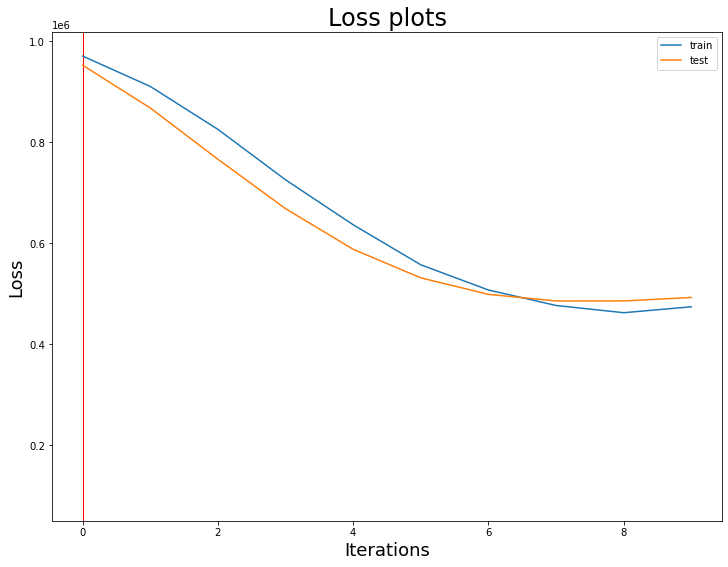

In [55]:
print(train_err[epoch - 1 ])
print(test_err[epoch - 1])
def visualize_graphs(train_err, test_err, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red", lw=1)
  plt.axvline(color="red", lw=1)
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  
  plt.plot(train_err, label="train")
  plt.plot(test_err, label="test")
  
  plt.ylim(50000)
  
  plt.legend(loc="upper right")
  
  
visualize_graphs(train_err, test_err, "Loss plots")

# Create Prediction File

After the model has been trained, we can then run it on the public test cases. The public test cases are given in the test_public.csv file. The same transformation we applied to the training dataset has to be done to the test_public.csv file in order to run the model on it.

In [21]:
predict = pd.read_csv("test_public.csv")

In [22]:
predict[["YR", "MON", "DAY", "HR", "WK"]] = predict[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
predict.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,17,3
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,17,3
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,17,3
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,17,3
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,17,3


In [28]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0


In [26]:
predict_x = getFeatureVectors(df_tr)

model.eval()
with torch.no_grad():
    o = model(predict_x)
    print (o)

predict_x.shape

tensor([[644.0263],
        [496.2859],
        [644.0263],
        ...,
        [854.5856],
        [742.9427],
        [646.2174]])


torch.Size([1710660, 72])

After getting the output from the model, there should be 320 datapoints. We can open the sampleSubmission.csv and then add a new column for the TRAVEL_TIME and put in our predicted travel time. The csv then can be saved.

In [27]:
filePath = "./submissions/my_pred5.csv"

df_sample = pd.read_csv("sampleSubmission.csv")

o = o.reshape(-1)
out = o.numpy()
for i in range(320):
    df_sample.at[i, "TRAVEL_TIME"] = out[i]

os.makedirs('./submissions/', exist_ok=True)
df_sample.to_csv(filePath, index=None)

# Saving Models

In [25]:
os.makedirs('./saved_models/', exist_ok=True)
torch.save(model.state_dict(), './saved_models/model_weights1.pth')

After saving a model, you can load it back again like this. 

In [32]:
new_model = Net()

In [33]:
# make sure the model is has the same "structure" so that the "weights" can be filled in.
new_model.load_state_dict(torch.load('./saves/model_weights1.pth'))

<All keys matched successfully>